# 価値反復法と反復方策法の実装
+ 例1.5を基に2つの手法の実演を行う

## 設定

In [1]:
%matplotlib inline

In [3]:
from typing import List, Optional

import numpy as np
import matplotlib.pyplot as plt

## 状態遷移確率と報酬の定義

In [9]:
# 状態や行動は0始まりのindexと思って、状態と行動の数だけ設定
n_state = 2
n_action = 3

# 状態遷移確率: P_t[i,j,k] = P_T(s'=i|s=j,a=k)とする
P_t = np.zeros((n_state,n_state,n_action))
P_t[0,0,0]=0.8
P_t[1,0,0]=0.2
P_t[0,0,1]=0
P_t[1,0,1]=1
P_t[0,0,2]=1
P_t[1,0,2]=0
P_t[0,1,0]=0
P_t[1,1,0]=1
# P_t[:,1,1:]は定義できないが一旦全部0にしておく

# 報酬関数 G[i,j]=g(s=i, a=j)
G = np.zeros((n_state, n_action))
G[0,0]=5
G[0,1]=10
G[0,2]=2
G[1,0]=1
# G[1,1:]は定義できないが、一旦全部0にしておく

# 価値反復法の実装
+ 割引率、閾値を設定後、価値関数の初期値$v_1(s)$を決めて、$v_{n+1}(s')$を以下のように更新する
$$
v_{n+1}(s) = \max_a \{g(s,a) + \gamma \sum_{s'} P_T(s'|s,a)v_n(s')\}
$$

+ 価値関数が収束していれば、以下の方法で決定方策$\pi(s)$を決める
$$
\pi(s) = arg\max_a \{g(s,a) + \gamma \sum_{s'} P_T(s'|s,a)v_{n+1}(s')\}
$$

In [10]:
# 繰り返しが収束しない場合のループの上限
max_loop = 1000

In [11]:
def value_iter_method(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    eps: float,
    max_loop: int = 1000,
    convergence_method: str = "inf_norm"
) -> (Optional[np.ndarray], Optional[np.ndarray], List[float], List[np.ndarray]):
    """　価値反復法の実装
    収束判定は教科書では2つ考えてあるので、それぞれの手法で判定を行えるようにしている

    + 入力:
        1. n_state: 状態数
        2. n_action: 行動数
        3: P_t: 状態遷移確率, 次状態×今状態×今行動の行列が入っている想定
        4: G: 報酬関数, 状態×行動の行列が入っている想定
        5. gamma: 割引率 \in [0, 1)
        6. eps: 収束判定で用いる閾値
        7. max_loop: 収束しない場合の設定, 大きい値を設定すればよい, max_loopまで更新したときは、警告出しても良いかも
        8. convergence_method: 収束判定に使っている評価値を設定するための文字列
            - convergence_method='inf_norm'の場合: 更新前後の状態関数(ベクトル)の最大値ノルムで評価する
            - convergence_method='min_max'の場合: 更新前後の状態関数(ベクトル)の最小の差と最大の差の差分で評価する
    + 出力: 
        1. est_value_vec: 推定された最適価値関数, 評価値が収束しない場合None
        2. est_pi_s: 推定された最適方策, 評価値が収束しない場合None
        3. convergence_val_history: convergence_method毎に計算された評価値の推移, デバッグ用
        4. value_func_history: 推定された最適価値関数の推移, デバッグ用

    Remark: 状態関数の初期値(curr_value_vec)を全部0に固定しているが、色々変えられるようにした方が良い
    """
    # convergence_methodが意図したものでない場合例外を投げる
    if convergence_method not in ('inf_norm', 'min_max'):
        raise ValueError(f"convergence_method is either 'abs' or 'min_max', convergence_method = '{convergence_method}'")
        
    # 初期設定
    curr_value_vec = np.zeros(n_state)
    convergence_val_history = []
    value_vec_history = []
    
    # 推定された価値関数と方策は収束しない場合は、Noneとする
    est_value_vec = None
    est_pi_s = None
    
    for ite in range(max_loop):
        # 価値関数の更新
        # print(curr_value_vec)
        # print(P_t * curr_value_vec[:,np.newaxis,np.newaxis])
        next_value_vec = (
            G # 状態×行動
            + gamma * (
                P_t * curr_value_vec[:,np.newaxis,np.newaxis] # value_vecをブローキャストして次状態×今状態×行動の行列を作る
            ).sum(axis=0) # 次状態を集約
        ).max(axis=1)
        print(next_value_vec)

        # 収束判定の評価値計算
        if convergence_method == "inf_norm":
            # inf normで評価
            convergence_val = np.abs(curr_value_vec - next_value_vec).max()
            pass
        elif convergence_method == "min_max":
            # 状態関数の差の最大、最小の差で評価
            dvalue_vec = next_value_vec - curr_value_vec
            convergence_val = (dvalue_vec).max() - (dvalue_vec).min()
            pass
        else:
            # 最初に例外投げているが、convergence_methodが増えても大丈夫なように想定外なら例外を投げるようにしておく
            raise ValueError(f"convergence_method is either 'abs' or 'min_max', convergence_method = '{convergence_method}'")

        # 計算結果の過程をリストに残す
        value_vec_history.append(next_value_vec)
        convergence_val_history.append(convergence_val)

        # 収束判定, 評価値が閾値以下なら方策も計算して、ループを抜ける
        if convergence_val_history[-1] < threshold:
            est_value_vec = next_value_vec
            est_pi_s = np.argmax(G + gamma * (P_t * est_value_vec[:,np.newaxis,np.newaxis]).sum(axis=0), axis=1)
            break
        else:
            curr_value_vec = next_value_vec
        pass
    return est_value_vec, est_pi_s, convergence_val_history, value_vec_history
    pass

In [12]:
# ハイパーパラメータの設定
gamma = 0.9
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=1,
)
est_value_func, est_pi_s

[10.  1.]


(None, None)

In [13]:
# ハイパーパラメータの設定
gamma = 0.9
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
)
est_value_func, est_pi_s

[10.  1.]
[12.38  1.9 ]
[14.2556  2.71  ]
[15.751832  3.439   ]
[16.96033904  4.0951    ]
[17.94856211  4.68559   ]
[18.76637092  5.217031  ]
[19.45085264  5.6953279 ]
[20.02977292  6.12579511]
[20.52407962  6.5132156 ]
[20.94971614  6.86189404]
[21.31893655  7.17570464]
[21.64126115  7.45813417]
[21.92417218  7.71232075]
[22.1736217   7.94108868]
[22.39440359  8.14697981]
[22.59042695  8.33228183]
[22.76491813  8.49905365]
[22.92057071  8.64914828]
[23.0596576   8.78423345]
[23.1841155   8.90581011]
[23.29560898  9.0152291 ]
[23.3955797   9.11370619]


(array([23.3955797 ,  9.11370619]), array([0, 0], dtype=int64))

In [14]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
)
est_value_func, est_pi_s

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
[32.97907043 14.72959811]
[33.33011691 14.99311821]
[33.66361106 15.24346229]
[33.98043051 15.48128918]
[34.28140898 15.70722472]
[34.56733853 15.92186349]
[34.83897161 16.12577031]
[35.09702303 16.3194818 ]
[35.34217187 16.50350771]
[35.57506328 16.67833232]
[35.79631012 16.8444157 ]
[36.00649461 17.00219492]
[36.20616988 17.15208517]
[36.39586139 17.29448091]
[36.57606832 17.42975687]


(array([38.14984398, 18.6111432 ]), array([2, 0], dtype=int64))

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
[32.97907043 14.72959811]
[33.33011691 14.99311821]
[33.66361106 15.24346229]
[33.98043051 15.48128918]
[34.28140898 15.70722472]
[34.56733853 15.92186349]
[34.83897161 16.12577031]
[35.09702303 16.3194818 ]
[35.34217187 16.50350771]
[35.57506328 16.67833232]
[35.79631012 16.8444157 ]
[36.00649461 17.00219492]
[36.20616988 17.15208517]
[36.39586139 17.29448091]
[36.57606832 17.42975687]


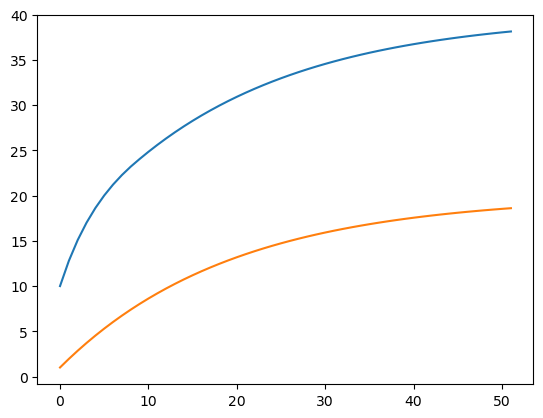

In [15]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

(_, _, _, history_value_vec) = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
    convergence_method="inf_norm",
)

print(len(history_value_vec))

plt.plot(np.array(history_value_vec)[:,0])
plt.plot(np.array(history_value_vec)[:,1])
plt.show()

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
25


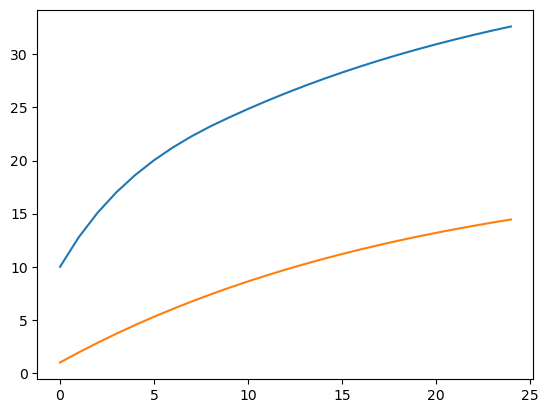

In [16]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

(_, _, _, history_value_vec) = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
    convergence_method="min_max",
)
print(len(history_value_vec))

plt.plot(np.array(history_value_vec)[:,0])
plt.plot(np.array(history_value_vec)[:,1])
plt.show()

# 方策反復法の実装
## アルゴリズム
+ 以下の1-4を実行する
1. 初期の決定方策$\pi^d_1$($|S|$個の要素のベクトル)を決める。
2. 決定方策$\pi^d_n$から期待ベルマン方程式から期待価値関数$V^{\pi^d_n}$($|S|$個の要素のベクトル)を計算する。$|S|$個の連立方程式を解けばよい:
$$
V^{\pi^d_n}(s)=g(s,\pi^d_n(s)) + \gamma \sum_{s'} p_T(s'|s,\pi^d_n(s))) V^{\pi^d_n}(s), for each s
$$
3. 改善方策$\pi^{d}_{n+1}(s)$を求める:
$$
\pi^{d}_{n+1}(s)=arg\max_a \{g(s,a) + \gamma \sum_{s'} p_T(s'|s,a)V^{\pi^d_n}(s')\}
$$
4. 収束判定: $\pi^d_n(s)=\pi^d_{n+1}(s), \forall s$であるならば、終了, そうでなければn=n+1として2に戻る


In [17]:
def policy_iter_method(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    max_loop: int = 1000,
    init_pi_s: Optional[np.ndarray] = None
) -> (np.ndarray, Optional[np.ndarray], List[float], List[np.ndarray]):
    """　方策反復法の実装

    + 入力:
        1. n_state: 状態数
        2. n_action: 行動数
        3: P_t: 状態遷移確率, 次状態×今状態×今行動の行列が入っている想定
        4: G: 報酬関数, 状態×行動の行列が入っている想定
        5. gamma: 割引率 \in [0, 1)
        6. max_loop: 収束しない場合の設定, 大きい値を設定すればよい, max_loopまで更新したときは、警告出しても良いかも
        7. init_pi_s: 決定方策の初期値, Noneの場合、全ての状態で0番の行動を選ぶこととする
        
    + 出力: 
        1. est_V_pi: 推定された最適価値関数
        2. est_pi_s: 推定された最適方策, 評価値が収束しない場合None
        3. pi_s_history: 各ステップで得られた推定された最適方策の推移, デバッグ用
        4. value_func_history: 各ステップで得られた推定された最適価値関数の推移, デバッグ用
    """
    # 各結果の推移を記録する変数の設定
    V_pi_history = []
    pi_s_history = []
    est_pi_s = None
    
    # 決定方策の初期化
    curr_pi_s = init_pi_s if init_pi_s is not None else np.zeros(n_state, dtype=int)
    for _ in range(max_loop):
        # 期待価値関数の計算
        #  - gamma*P_t[np.arange(n_state), :, curr_pi_s]
        est_V_pi = np.linalg.solve(
            np.eye(n_state) - gamma*np.vstack([P_t[:,i,curr_pi_s[i]] for i in range(n_state)]), # 今状態×次状態の行列にしたいので、次状態を列方向に並べる
            np.array([G[i, curr_pi_s[i]] for i in range(n_state)]),
        )
        print(est_V_pi)
        
        # 改善方策の計算
        next_pi_s = np.argmax(
            G # g(s,a)部分
            + gamma * (P_t * est_V_pi[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
            axis=1,
        ).astype(int)
    
        # 計算過程の記録
        V_pi_history.append(est_V_pi)
        pi_s_history.append(next_pi_s)
    
        # 収束判定
        if (next_pi_s == curr_pi_s).all():
            est_pi_s = next_pi_s
            break
        else:
            curr_pi_s = next_pi_s

    return(est_V_pi, est_pi_s, pi_s_history, V_pi_history)

In [18]:
gamma = 0.9
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[24.28571429 10.        ]


(array([24.28571429, 10.        ]),
 array([0, 0]),
 [array([0, 0])],
 [array([24.28571429, 10.        ])])

In [19]:
gamma = 0.9
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[[0.8 0.2]
 [0.  1. ]]


(array([24.28571429, 10.        ]),
 array([0, 0]),
 [array([0, 0])],
 [array([24.28571429, 10.        ])])

In [12]:
gamma = 0.5
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

(array([11.,  2.]),
 array([1, 0]),
 [array([1, 0]), array([1, 0])],
 [array([8.66666667, 2.        ]), array([11.,  2.])])

In [13]:
gamma = 0.95
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

(array([40., 20.]),
 array([2, 0]),
 [array([2, 0]), array([2, 0])],
 [array([36.66666667, 20.        ]), array([40., 20.])])

# 試行錯誤の跡

In [ ]:
# # 各結果の推移を記録する変数の設定
# V_pi_history = []
# pi_s_history = []

# # 決定方策の初期化
# curr_pi_s = np.zeros(n_state, dtype=int) + 2

# for _ in range(max_loop):
#     # 期待価値関数の計算
#     #  - gamma*P_t[np.arange(n_state), :, curr_pi_s]
#     est_V_pi = np.linalg.solve(
#         np.eye(n_state) - gamma*np.vstack([P_t[:,i,curr_pi_s[i]] for i in range(n_state)]), # 今状態×次状態の行列にしたいので、次状態を列方向に並べている
#         np.array([G[i, curr_pi_s[i]] for i in range(n_state)]),
#     )
    
#     # 改善方策の計算
#     next_pi_s = np.argmax(
#         G # g(s,a)部分
#         + gamma * (P_t * est_V_pi[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
#         axis=1,
#     ).astype(int)

#     # 計算過程の記録
#     V_pi_history.append(est_V_pi)
#     pi_s_history.append(next_pi_s)

#     # 収束判定
#     if (next_pi_s == curr_pi_s).all():
#         break
#     else:
#         curr_pi_s = next_pi_s

# V_pi_history

# pi_s_history



# G.shape

# curr_pi_s

# P_t.shape

# # 初期設定
# curr_value_vec = np.zeros(n_state)
# inf_norm_history = []
# value_vec_history = []

# # 推定された価値関数と方策は収束しない場合は、Noneとする
# est_value_vec = None
# est_pi_s = None

# for ite in range(max_loop):
#     # 価値関数の更新
#     next_value_vec = (
#         G # 状態×行動
#         + gamma * (
#             P_t * curr_value_vec[:,np.newaxis,np.newaxis] # value_vecをブローキャストして次状態×今状態×行動の行列を作る
#         ).sum(axis=0) # 次状態を集約
#     ).max(axis=1)
#     # 現在の状態と前の状態のinf normを格納しておく
#     inf_norm_history.append(np.abs(curr_value_vec - next_value_vec).max())
#     value_vec_history.append(next_value_vec)

#     # 収束判定
#     if inf_norm_history[-1] < threshold:
#         est_value_vec = next_value_vec
#         est_pi_s = np.argmax(G + gamma * (P_t * est_value_vec[:,np.newaxis,np.newaxis]).sum(axis=0), axis=1)
#         break
#     else:
#         curr_value_vec = next_value_vec

# value_vec_history

# est_pi_s

# est_value_vec

# plt.plot(inf_norm_history)

# np.abs(curr_value_vec - next_value_vec).max()

# # [
# #     G[s,:] + gamma * (P_t[:,s,:] * value_vec[:,np.newaxis]).sum(axis=0)
# #     for s in range(n_state)
# # ]

